# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:10<00:00, 2273.04it/s]


In [23]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(160176, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 200K datapoints to work upon which got reduced to approx. 160K datapoints after all 
the text processing and data deduplication.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


Now I have a total of approx. 160K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Logistic Regression Classifier. Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

In [28]:
final_TBS = final.sort_values('Time')

In [29]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now the values are sorted on the basis of Time. We know that by default the values are sorted in ascending order. 

# Obtaining Train, CV and Test Data:

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case are the 'Score' & 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

In [30]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [31]:
df.head()

,Score,Preprocessed_Reviews
138706,1,witty little book makes son laugh loud recite ...
138683,1,remember seeing show aired television years ag...
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...


In [32]:
cleandf = df[:100000]

Basically we are taking a total of 100K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 70,000 
            # of Datapoints in CV data = 10,000
            # of Datapoints in Test data = 20,000

In [33]:
Tr_df = cleandf[:70000]
CV_df = cleandf[70000:80000]
Te_df = cleandf[80000:100000]

In [34]:
Tr_df.shape

(70000, 2)

In [35]:
CV_df.shape

(10000, 2)

In [36]:
Te_df.shape

(20000, 2)

Yes everything is working as expected: There are 70K points in the Training data, 10K points in the CV data and 20K
points in the Test data.

Now we can split the data as features in X and the class label in Y.

In [37]:
X_Train = Tr_df['Preprocessed_Reviews']
Y_Train = Tr_df['Score']

X_CV = CV_df['Preprocessed_Reviews']
Y_CV = CV_df['Score']

X_Test = Te_df['Preprocessed_Reviews']
Y_Test = Te_df['Score']

In [38]:
Y_Train.value_counts()

1    60269
0     9731
Name: Score, dtype: int64

In [39]:
Y_CV.value_counts()

1    8266
0    1734
Name: Score, dtype: int64

In [40]:
Y_Test.value_counts()

1    16635
0     3365
Name: Score, dtype: int64

As expected, this is an imbalanced real world dataset. 

# Applying Logistic Regression :-

# [5.1] Applying Logistic Regression on BOW :-

# [5.1.1] Applying Logistic Regression with L1 regularization on BOW :- 

In [531]:
count_vect = CountVectorizer()
count_vect.fit(X_Train) #Again the fit function is applied only on the Train data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical vector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [532]:
X_Train_BOW = count_vect.transform(X_Train)
X_CV_BOW = count_vect.transform(X_CV)
X_Test_BOW = count_vect.transform(X_Test)

In [533]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_Train.shape,Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_Test.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_Train_BOW.shape,Y_Train.shape)
print(X_CV_BOW.shape,Y_CV.shape)
print(X_Test_BOW.shape,Y_Test.shape)

Shapes before the BOW Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(70000, 49871) (70000,)
(10000, 49871) (10000,)
(20000, 49871) (20000,)


# Hyperparameter Tuning on the BOW Representation (For L1 Regularization):- 

Here since I am not using elastic net (which would have required 2 hyperparameters to be obtained, one for L1 
regularization and the other for L2 Regularization), I only care about one hyperparameter ie. one value of lambda, 
which I am considering from 10^-6 to 10^6. 

We can easily apply GridSearchCV in this case since we are only focused on a single Hyperparameter. If we had to obtain the best values for a lot of hyperparameters, GridSearchCV won't have been the best option considering its
time complexity.

In [534]:
lambda_hyperparam =[]
#initializing an empty list

for a in range(-6,7,2):
    lambda_hyperparam.append(10**a)

In [535]:
print(lambda_hyperparam)

[1e-06, 0.0001, 0.01, 1, 100, 10000, 1000000]


Here we have generated a list with the even powered values of the hyperparameter from 10^-6 to 10^6. The necessary 
packages are imported as follows:- 

In [536]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

Now to provide the necessary parameter values to be used in GridSearchCV it is to be noted that we require a 
dictionary and not a list. Therefore a dictionary named 'tuned_parameters' is hence obtained as follows:

In [537]:
tuned_parameters = {'C':lambda_hyperparam}

Again, column standardization is very important since we are calculating the distances of the datapoints from the 
hyperplane in consideration. Standardization is carried out as follows where X_Train_SCBOW (Scaled X_Train) is 
obtained after scaling the vectorized BOW representation. (Similarly we obtain the scaled vector for Test data as well).

In [538]:
Scaler1 = StandardScaler(with_mean=False)
X_Train_SCBOW = Scaler1.fit_transform(X_Train_BOW)
X_CV_SCBOW = Scaler1.transform(X_CV_BOW)
X_Test_SCBOW = Scaler1.transform(X_Test_BOW)

In [540]:
warnings.filterwarnings('ignore')

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

logi1 = LogisticRegression(penalty='l1',fit_intercept=False,class_weight='balanced')
BOW_model1 = GridSearchCV(logi1,tuned_parameters,scoring='roc_auc', cv=3,n_jobs=-1)

BOW_model1.fit(X_Train_SCBOW,Y_Train)

Train_BOW_AUC_L1 = BOW_model1.cv_results_['mean_train_score']
CV_BOW_AUC_L1 = BOW_model1.cv_results_['mean_test_score'] 

Plotting the graph to obtain the best value of C:-

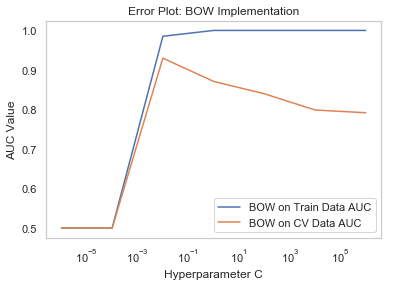

In [542]:
plt.plot(lambda_hyperparam,Train_BOW_AUC,label="BOW on Train Data AUC")
plt.plot(lambda_hyperparam,CV_BOW_AUC,label ="BOW on CV Data AUC")
plt.xscale('log')

plt.legend()

plt.title("Error Plot: BOW Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.grid(False)
plt.show()

From this graph that we obtained we can choose the best value of the hyperparameter as follows:
    * Highest value of CV AUC Value
    * Smallest difference between the Train and CV AUC curves. 
    
Basis this criteria of choosing the value of C, the best value of C = 10^-2 where the CV AUC Value > 0.9. This can
be confirmed by the following code snippet using the best_params_ attribute.

In [543]:
print(BOW_model.best_params_)

{'C': 0.01}


# Testing with the Test Data for BOW Representation (For L1 Regularization):-

In [544]:
logi_test1 = LogisticRegression(penalty='l1', C=0.01,fit_intercept=False,class_weight='balanced')
logi_test1.fit(X_Train_SCBOW,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [545]:
X_Train_SCBOW.shape

(70000, 49871)

In [546]:
Y_Train.shape

(70000,)

In [547]:
X_Test_SCBOW.shape

(20000, 49871)

In [548]:
Y_Test.shape

(20000,)

In [549]:
from sklearn.metrics import roc_curve,auc

train_fpr1,train_tpr1,thresholds = roc_curve(Y_Train,logi_test1.predict_proba(X_Train_SCBOW)[:,1])
test_fpr1,test_tpr1,thresholds = roc_curve(Y_Test,logi_test1.predict_proba(X_Test_SCBOW)[:,1])

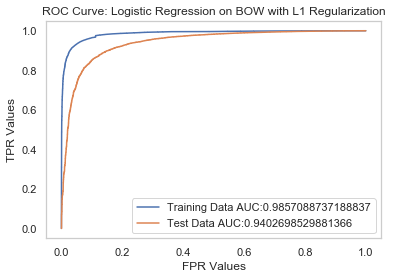

In [551]:
import matplotlib.pyplot as plt

plt.plot(train_fpr1,train_tpr1,label = 'Training Data AUC:' + str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1, label = 'Test Data AUC:' + str(auc(test_fpr1,test_tpr1)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on BOW with L1 Regularization')

plt.grid(False)
plt.show()

<b> <font color="black"> User Defined Function to obtain the best value of Threshold with Best Tradeoff between 
TPR and FPR :- </font> </b>

In [552]:
def matrixpredict(data,thresholds,tpr,fpr):
    matrixpredict.best_tradeoff = tpr*(1-fpr)
    matrixpredict.ideal_threshold = thresholds[matrixpredict.best_tradeoff.argmax()]
    
    predictions = []
    
    for i in data:
        if i>= matrixpredict.ideal_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<b> <font color="black"> User Defined Function to plot the Heatmap of The Confusion Matrix for the Training Data: </font> </b>

In [553]:
import seaborn as sns

def plottrainmatrix (train_matrix):
    sns.set_style("whitegrid")
    
    labels = [0,1]
    
    print("-"*20, "Training Confusion Matrix", "-"*20)
    print(" ")
    print("The Training Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(train_matrix,
                annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<b> <font color="black"> User Defined Function to plot the HeatMap of The Confusion Matrix for the Test Data: </font> </b>

In [554]:
import seaborn as sns

def plottestmatrix (test_matrix):
    labels = [0,1]
    
    print("-"*20, "Test Data Confusion Matrix", "-"*20)
    print(" ")
    print("The Test Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
   
    sns.heatmap(test_matrix,annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, 
                yticklabels=labels,annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()     

In [555]:
Y_Train_pred1 = logi_test1.predict_proba(X_Train_SCBOW)[:,1]
Y_Test_pred1 = logi_test1.predict_proba(X_Test_SCBOW)[:,1]

The Train Data Confusion Matrix looks as follows:-

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.8865294862503701
Threshold for Maximum Value of tpr*(1-fpr) : 0.463


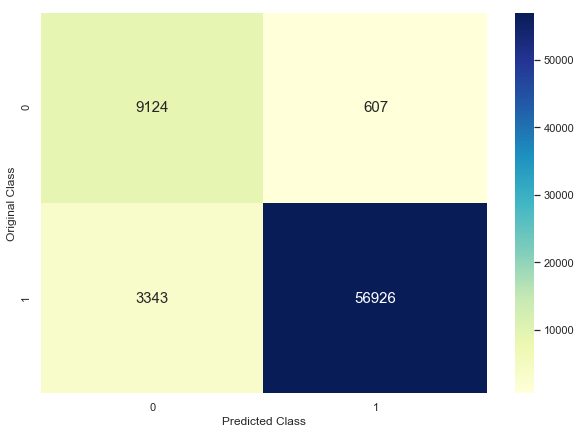

In [556]:
BOW_Train1 = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred1,thresholds,train_tpr1,train_fpr1))
plottrainmatrix(BOW_Train1)

Accuracy on the Train Data = (56926+9124)/70000 => 94.35%

Similarly the Test Data Confusion Matrix is as follows:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7686386005624654
Threshold for Maximum Value of tpr*(1-fpr) : 0.587


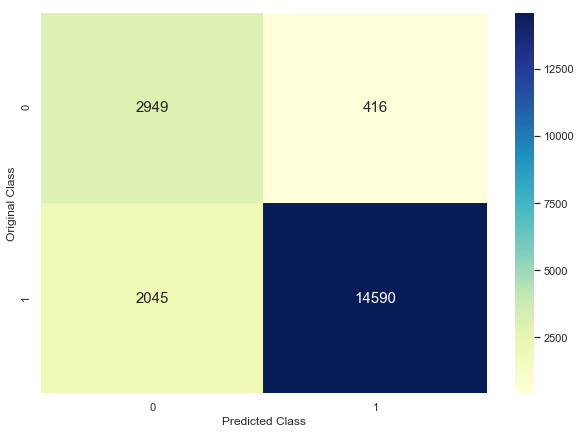

In [557]:
BOW_Test1 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred1,thresholds,test_tpr1,test_fpr1))
plottestmatrix(BOW_Test1)

Accuracy on the Test Data => (14590+2949)/20000 => 87.70 %

# [5.1.1.1] Calculating Sparsity on Weight Vector obtained using L1 Regularization on BOW :-

In [558]:
logi_clf1 = LogisticRegression(C=0.01,penalty='l1',class_weight='balanced')
logi_clf1.fit(X_Train_SCBOW,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [559]:
W = logi_clf1.coef_

The coef_ attribute returns the values of the Weights that suggest the feature importance in case the features are 
not multicollinear (W is an nd-array).
Sparsity of a vector is defined as follows :- 
        * Number of Zero elements in a vector / Total Number of elements in the vector
        
This value could be calculated as follows:

In [560]:
(W.shape[0]*W.shape[1] - np.count_nonzero(W)) / (W.shape[0]*W.shape[1])

0.8855246536063043

W.shape[0] * W.shape[1] returns the number of elements present in the n-dimensional array whereas count_nonzero
in numpy returns the number of non-zero elements. 

# [5.1.2] Applying Logistic Regression with L2 regularization on BOW :-

# Hyperparameter Tuning on the BOW Representation (For L2 Regularization):- 

In [562]:
warnings.filterwarnings('ignore')

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

logi2 = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced')
BOW_model2 = GridSearchCV(logi2,tuned_parameters,scoring='roc_auc', cv=3,n_jobs=-1)

BOW_model2.fit(X_Train_SCBOW,Y_Train)

Train_BOW_AUC_L2 = BOW_model2.cv_results_['mean_train_score']
CV_BOW_AUC_L2 = BOW_model2.cv_results_['mean_test_score'] 

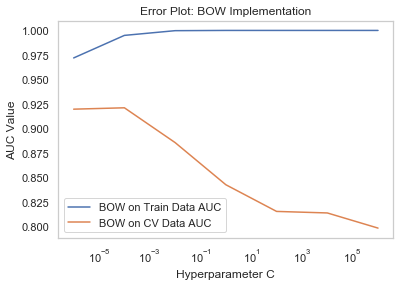

In [564]:
plt.plot(lambda_hyperparam,Train_BOW_AUC_L2,label="BOW on Train Data AUC")
plt.plot(lambda_hyperparam,CV_BOW_AUC_L2,label ="BOW on CV Data AUC")
plt.xscale('log')

plt.legend()

plt.title("Error Plot: BOW Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.grid(False)
plt.show()

In [565]:
print(BOW_model2.best_params_)

{'C': 0.0001}


Therefore, the best Value of the Hyperparameter C in this scenario is : 0.0001, which we will apply on the Test Dataset.

# Testing with the Test Data for BOW Representation (For L2 Regularization):-

Therefore on the Best value of C that has been obtained after carrying out the Hyperparameter Tuning, we fit the 
model on the Training Data as follows:

In [566]:
logi_test2 = LogisticRegression(C=0.0001,penalty='l2',fit_intercept=False,class_weight='balanced')
logi_test2.fit(X_Train_SCBOW,Y_Train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [567]:
from sklearn.metrics import auc,roc_curve

train_fpr2,train_tpr2,thresholds = roc_curve(Y_Train,logi_test2.predict_proba(X_Train_SCBOW)[:,1])
test_fpr2,test_tpr2,thresholds = roc_curve(Y_Test,logi_test2.predict_proba(X_Test_SCBOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

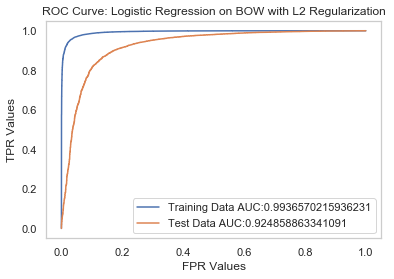

In [568]:
import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2,label ='Training Data AUC:' + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label = 'Test Data AUC:' + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on BOW with L2 Regularization')

plt.grid(False)
plt.show()

In [569]:
Y_Train_pred2 = logi_test2.predict_proba(X_Train_SCBOW)[:,1]
Y_Test_pred2 = logi_test2.predict_proba(X_Test_SCBOW)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.9258764203284484
Threshold for Maximum Value of tpr*(1-fpr) : 0.591


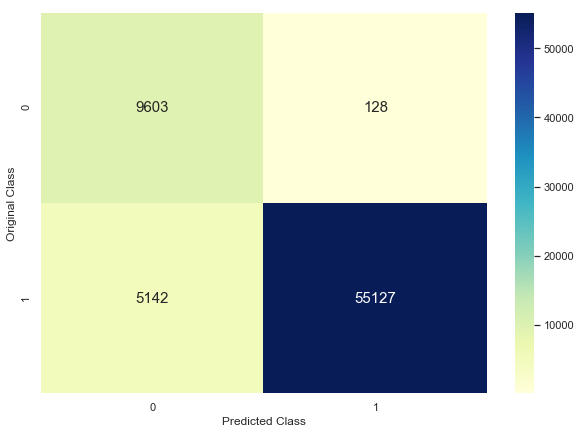

In [570]:
BOW_Train2 = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred2,thresholds,train_tpr2,train_fpr2))
plottrainmatrix(BOW_Train2)

Accuracy on Train Data = (55127+9603)/70000 => 92.53 %

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7497374938088163
Threshold for Maximum Value of tpr*(1-fpr) : 0.583


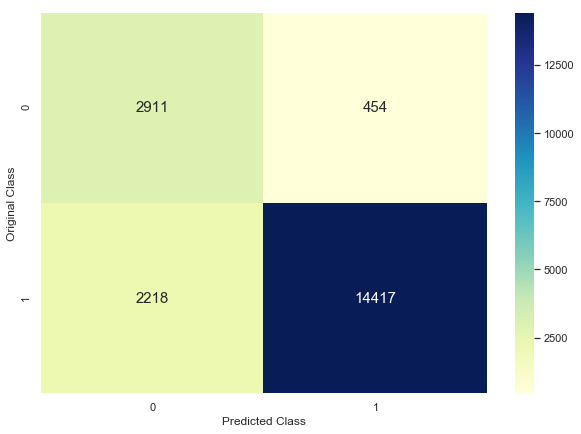

In [571]:
BOW_Test2 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred2,thresholds,test_tpr2,test_fpr2))
plottestmatrix(BOW_Test2)

Accuracy on Test Data = (14417 + 2911)/20000 => 86.64 %

# [5.1.2.1] Performing Pertubation Test (Multicollinearity Check) on BOW:-

Following are the Steps that we will perform to carry out the Pertubaton Test where we add a small Noise to the 
Training Data and again train the model on the Train data to check if there is a significant change to the weights 
obtained or not.

Therefore first I will generate a Random number with Gaussian Distribution : A mean of 0 and a variance equal to 0.110.

We already have obtained the Weights after fitting the model with the data X and the same has been stored in a 
variable called W.

In [572]:
Gaussian = np.random.normal(0,0.0110)
print(Gaussian)

0.005053611736121023


In [573]:
type(X_Train_SCBOW)

scipy.sparse.csr.csr_matrix

In [574]:
X_Train_SCBOW.shape

(70000, 49871)

As we see X_Train_SCBOW is a sparse matrix and we are basically to obtain a new Sparse matrix after adding this noise
"Gaussian" that we obtained to the same. Also the shape of the Training Data Matrix :- (70000,49871) as expected. 

In [575]:
X_Train_SCBOW.data = X_Train_SCBOW.data + Gaussian
#We need to add with .data because otherwise we get an error that says : Adding a Non-Zero Scalar to a Sparse matrix
#is not possible

logi_clf1.fit(X_Train_SCBOW,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

We have added the variable "Gaussian" to X_Train_SCBOW and then fit the model now on this Training Data with the small noise added to the matrix. Now this logi_clf1's weight vector is obtained and stored in the variable 'W_dash' as follows:

In [576]:
W_dash = logi_clf1.coef_

In [577]:
print(np.count_nonzero(W))
print(np.count_nonzero(W_dash))

5709
5768


Now add a small value to both the vectors, such as 10^(-6) to make sure that when we are calculating the absolute
change in the values of the weight vectors there is no problem of division by zero for these sparse vectors.

In [578]:
W = W + 10**(-6)
W_dash = W_dash + 10**(-6)

In [579]:
percentage_change_vector = abs((W - W_dash)/W_dash) * 100
print(np.count_nonzero(percentage_change_vector))

5815


We basically have obtained 4628 non-zero elements in the "percentage_change_vector" where we have obtained the absolute changes in the Percentage values between the 2 vectors. Now what we have to do is as follows:

 *Find the percentile values for the "percentage_change_vector" and find the value of the percetile where this 
  value is rising sharply. 
 *The value corresponding to this particular percentile becomes our threshold and we are to obtain the feature names
  with the percentile values higher than this value of the threshold. 
  
  First we obtain the Percentile values that are multiples of 10.

In [580]:
Percentiles1 = []
Percentile_values1 = []

for i in range(0,101,10):
    Percentiles1.append(i)
    Percentile_values1.append(np.percentile(percentage_change_vector,i))

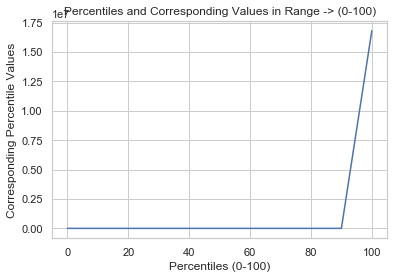

In [581]:
import matplotlib.pyplot as plt

plt.plot(Percentiles1,Percentile_values1)

plt.xlabel('Percentiles (0-100)')
plt.ylabel('Corresponding Percentile Values')
plt.title('Percentiles and Corresponding Values in Range -> (0-100)')
plt.show()

We see that this percentile value where there is the sudden spike is greater than the 85th percentile. Therefore we 
zoom in further to the percentile values in this particular range.

In [582]:
Percentiles2 = []
Percentile_values2 = []

for i in range(85,101):
    Percentiles2.append(i)
    Percentile_values2.append(np.percentile(percentage_change_vector,i))

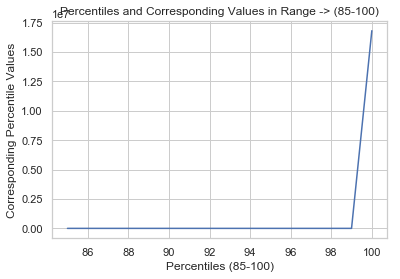

In [583]:
import matplotlib.pyplot as plt

plt.plot(Percentiles2,Percentile_values2)

plt.xlabel('Percentiles (85-100)')
plt.ylabel('Corresponding Percentile Values')
plt.title('Percentiles and Corresponding Values in Range -> (85-100)')
plt.show()

Again we see that the spike is after the 99th percentile. Now we increment the percentiles with a step size of 0.1 
and obtain the percentile values for 99.1,99.2,..... and so on.

In [584]:
Percentiles3 = []
Percentile_values3 = []

for i in range(99,101):
    while i<=100:
        Percentiles3.append(i)
        Percentile_values3.append(np.percentile(percentage_change_vector,i))
        i +=0.1

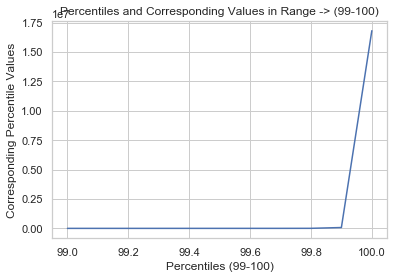

In [585]:
import matplotlib.pyplot as plt

plt.plot(Percentiles3,Percentile_values3)

plt.xlabel('Percentiles (99-100)')
plt.ylabel('Corresponding Percentile Values')
plt.title('Percentiles and Corresponding Values in Range -> (99-100)')
plt.show()

Also we obtain a list corresponding to all the values for the percentiles in the range of (99,100), and our threshold
is the value after which there is a sudden rise in the value. 

In [586]:
ReqdPercentage_change = []
for i in range(99,100):
    while i<=100:
        ReqdPercentage_change.append(np.percentile(percentage_change_vector,i))
        i+=0.1
print(ReqdPercentage_change)        

[97.42461525199663, 99.93299733902609, 101.12495443608012, 124.25556748261874, 185.52165813583153, 304.1209687702895, 552.9602606134013, 1080.4219480830525, 4093.0552326301877, 71614.3683446396, 16816163.06272669]


Therefore the threshold in this scenario is as follows (stored in the variable "thresh"):-   

In [587]:
thresh = ReqdPercentage_change[-2]

In [588]:
type(percentage_change_vector)

numpy.ndarray

In [589]:
len(percentage_change_vector[0])
#percentage_change_vector is a numpy nd-array.

49871

In [590]:
#All the features above the Threshold value are obtained as follows:

feature_names = count_vect.get_feature_names()
number_of_points_above_threshold = 0
features_above_threshold = []

for i in range(0,len(percentage_change_vector[0])):
    if percentage_change_vector[0][i]>thresh:
        number_of_points_above_threshold +=1
        features_above_threshold.append(feature_names[i])
print("Number of datapoints above the Threshold: " + str(number_of_points_above_threshold))
print("="*100)
print("Feature Names above the Threshold value are as follows :")
print(features_above_threshold)

Number of datapoints above the Threshold: 50
Feature Names above the Threshold value are as follows :
['advertizes', 'aguave', 'allitle', 'assn', 'barson', 'blechhh', 'chicobags', 'chipsters', 'citations', 'coatepec', 'conceptbad', 'darwish', 'dippings', 'downey', 'eesnyderif', 'fagin', 'fgound', 'glasgow', 'gobino', 'goofily', 'impractical', 'ippodo', 'italo', 'leon', 'looonnggg', 'miled', 'mothering', 'naaaaa', 'namby', 'neary', 'necking', 'nomol', 'oeste', 'ofmsg', 'perle', 'prectice', 'recomed', 'recommendedc', 'sabrina', 'signaled', 'stroopwafeln', 'sunflowery', 'takingmore', 'tk', 'torque', 'toxicant', 'trebbiano', 'uncomprehending', 'underlining', 'vez']


# [5.1.3] Feature Importance on BOW :-

In [591]:
logi_clf1.fit(X_Train_SCBOW,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [592]:
logi_clf1.classes_

array([0, 1])

Now we obtain all the weights in a variable called W_ds and we sort the values such that the first values are the 
most important features for the negative class and the values at the end are the most important features of the
positive class. 

Basically we are only getting the weight values for the features in the increasing order of importance for the positive class. We use argsort() to obtain the corresponding indices.

In [593]:
W_ds = list(logi_clf1.coef_)
sorted_weights = list(np.argsort(W_ds))
ordered_weights = sorted_weights[0]

print("The length of the ordered weights vector is as follows: " + str(len(ordered_weights)))
print("The ordered_weights variable looks like as follows:")
print(ordered_weights)

The length of the ordered weights vector is as follows: 49871
The ordered_weights variable looks like as follows:
[29484 12421 49097 ... 11490  4004 19021]


Now we basically flip the nd-array using the numpy flip() function so that the weights are sorted in the decreasing order of their importance to the positive class.

In [594]:
ordered_weights_reversed = list(np.flip(ordered_weights))
len(ordered_weights_reversed)

49871

# [5.1.3.1] Top 10 Important Features of Positive Class for BOW (Set 1) :-

In [595]:
print("The Top 10 Important Features of the Positive Class are as follows:")   
print("="*100) 
for i in ordered_weights_reversed[0:10]:
    print(feature_names[i], "-->",round(W_ds[0][i],3))

The Top 10 Important Features of the Positive Class are as follows:
great --> 0.685
best --> 0.536
delicious --> 0.496
good --> 0.403
perfect --> 0.375
love --> 0.368
loves --> 0.318
excellent --> 0.318
highly --> 0.313
wonderful --> 0.272


# [5.1.3.2] Top 10 Important Features of Negative Class for BOW (Set 1) :-

In [634]:
print("The Top 10 Important Features of the Negative Class are as follows:")   
print("="*100) 
for i in ordered_weights[0:10]:
    print(feature_names[i], "-->",round(W_ds[0][i],3))

The Top 10 Important Features of the Negative Class are as follows:
not --> -0.631
disappointed --> -0.251
worst --> -0.226
terrible --> -0.204
awful --> -0.185
horrible --> -0.169
thought --> -0.169
disappointing --> -0.168
unfortunately --> -0.165
money --> -0.144


# [5.2] Applying Logistic Regression on TFIDF :-

# [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF :- 

In [597]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_Train)

# Again fit is carried out only on the Training data. fit() internally stores the parameters that will be used to 
#convert the Text to a numerical vector. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [598]:
X_Train_TFIDF = tf_idf_vect.transform(X_Train)
X_CV_TFIDF = tf_idf_vect.transform(X_CV)
X_Test_TFIDF = tf_idf_vect.transform(X_Test)

In [599]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_Train.shape,Y_Train.shape)
print(X_CV.shape,Y_CV.shape)
print(X_Test.shape,Y_Test.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_Train_TFIDF.shape,Y_Train.shape)
print(X_CV_TFIDF.shape,Y_CV.shape)
print(X_Test_TFIDF.shape,Y_Test.shape)

Shapes before the TFIDF Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes after the TFIDF Vectorization was carried out:
(70000, 40652) (70000,)
(10000, 40652) (10000,)
(20000, 40652) (20000,)


# Hyperparameter Tuning on the TFIDF Representation (For L1 Regularization):- 

In [600]:
Scaler2 = StandardScaler(with_mean=False)
X_Train_SCTFIDF = Scaler2.fit_transform(X_Train_TFIDF)
X_CV_SCTFIDF = Scaler2.transform(X_CV_TFIDF)
X_Test_SCTFIDF = Scaler2.transform(X_Test_TFIDF)

In [601]:
logi3 = LogisticRegression(penalty='l1',fit_intercept=False,class_weight='balanced')
TFIDF_model1 = GridSearchCV(logi3,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

TFIDF_model1.fit(X_Train_SCTFIDF,Y_Train)

Train_TFIDF_AUC_L1 = TFIDF_model1.cv_results_['mean_train_score']
CV_TFIDF_AUC_L1 = TFIDF_model1.cv_results_['mean_test_score'] 

Plotting the graph to obtain the Best value of C:-

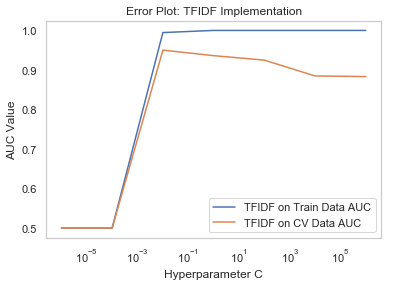

In [602]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_TFIDF_AUC_L1,label="TFIDF on Train Data AUC")
plt.plot(lambda_hyperparam,CV_TFIDF_AUC_L1,label ="TFIDF on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: TFIDF Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [603]:
print(TFIDF_model1.best_params_)

{'C': 0.01}


Therefore the best value of the Hyperparameter hence obtained is for C=0.01 which we will use to Train on the Training Data.

# Testing with the Test Data for TFIDF Representation (For L1 Regularization):-

In [604]:
logi_test3 = LogisticRegression(penalty='l1',C=0.01,fit_intercept=False,class_weight='balanced')
logi_test3.fit(X_Train_SCTFIDF,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [605]:
X_Train_SCTFIDF.shape

(70000, 40652)

In [606]:
Y_Train.shape

(70000,)

In [607]:
X_Test_SCTFIDF.shape

(20000, 40652)

In [608]:
Y_Test.shape

(20000,)

In [609]:
from sklearn.metrics import roc_curve,auc

train_fpr3,train_tpr3,thresholds = roc_curve(Y_Train,logi_test3.predict_proba(X_Train_SCTFIDF)[:,1])
test_fpr3,test_tpr3,thresholds = roc_curve(Y_Test,logi_test3.predict_proba(X_Test_SCTFIDF)[:,1])

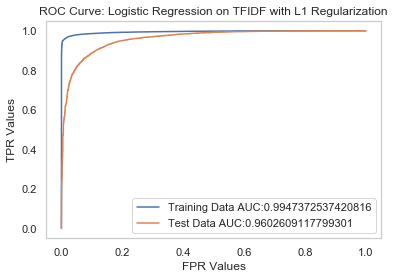

In [610]:
import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3,label ='Training Data AUC:' + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3,label = 'Test Data AUC:' + str(auc(test_fpr3,test_tpr3)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on TFIDF with L1 Regularization')

plt.grid(False)
plt.show()

In [611]:
Y_Train_pred3 = logi_test3.predict_proba(X_Train_SCTFIDF)[:,1]
Y_Test_pred3 = logi_test3.predict_proba(X_Test_SCTFIDF)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.9488506926689493
Threshold for Maximum Value of tpr*(1-fpr) : 0.737


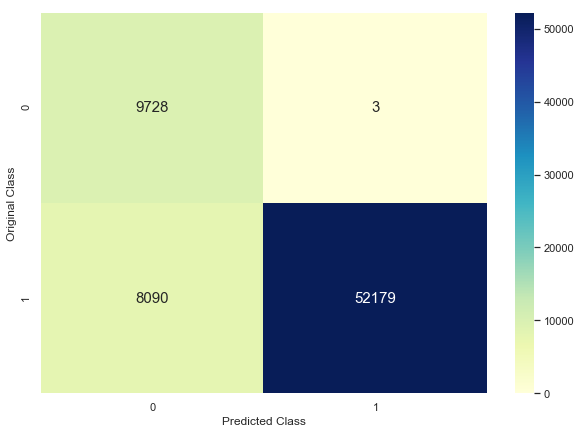

In [612]:
TFIDF_Train1 = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred3,thresholds,train_tpr3,train_fpr3))
plottrainmatrix(TFIDF_Train1)

Accuracy on the Train Data = (52179+9728)/70000 => 88.43%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7994715665559511
Threshold for Maximum Value of tpr*(1-fpr) : 0.638


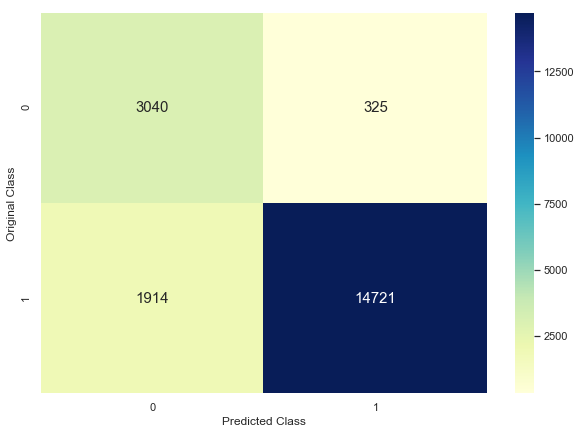

In [613]:
TFIDF_Test1 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred3,thresholds,test_tpr3,test_fpr3))
plottestmatrix(TFIDF_Test1)

Accuracy on the Test Data = (14721+3040)/20000 => 88.80%

# [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF :- 

# Hyperparameter Tuning on the TFIDF Representation (For L2 Regularization):- 

In [614]:
logi4 = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced')
TFIDF_model2 = GridSearchCV(logi4,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

TFIDF_model2.fit(X_Train_SCTFIDF,Y_Train)

Train_TFIDF_AUC_L2 = TFIDF_model2.cv_results_['mean_train_score']
CV_TFIDF_AUC_L2 = TFIDF_model2.cv_results_['mean_test_score'] 

Plotting the graph to obtain the Best Value of C:

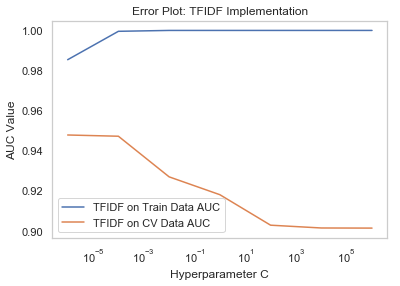

In [615]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_TFIDF_AUC_L2,label="TFIDF on Train Data AUC")
plt.plot(lambda_hyperparam,CV_TFIDF_AUC_L2,label ="TFIDF on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: TFIDF Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [616]:
print(TFIDF_model2.best_params_)

{'C': 1e-06}


# Testing with the Test Data for TFIDF Representation (For L2 Regularization) :-

In [617]:
logi_test4 = LogisticRegression(penalty='l2',C=10**(-6),fit_intercept=False,class_weight='balanced')
logi_test4.fit(X_Train_SCTFIDF,Y_Train)

LogisticRegression(C=1e-06, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [618]:
X_Train_SCTFIDF.shape

(70000, 40652)

In [619]:
Y_Train.shape

(70000,)

In [620]:
X_Test_SCTFIDF.shape

(20000, 40652)

In [621]:
Y_Test.shape

(20000,)

In [622]:
from sklearn.metrics import roc_curve,auc

train_fpr4,train_tpr4,threshold = roc_curve(Y_Train,logi_test4.predict_proba(X_Train_SCTFIDF)[:,1])
test_fpr4,test_tpr4,threshold = roc_curve(Y_Test,logi_test4.predict_proba(X_Test_SCTFIDF)[:,1])

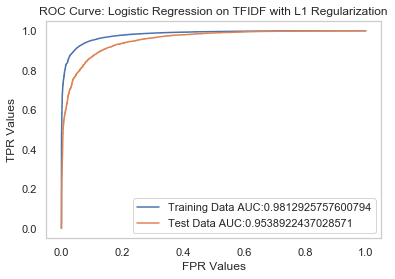

In [623]:
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4,label ='Training Data AUC:' + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4,label = 'Test Data AUC:' + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on TFIDF with L1 Regularization')

plt.grid(False)
plt.show()

In [624]:
Y_Train_pred4 = logi_test4.predict_proba(X_Train_SCTFIDF)[:,1]
Y_Test_pred4 = logi_test4.predict_proba(X_Test_SCTFIDF)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.8686500799393649
Threshold for Maximum Value of tpr*(1-fpr) : 0.378


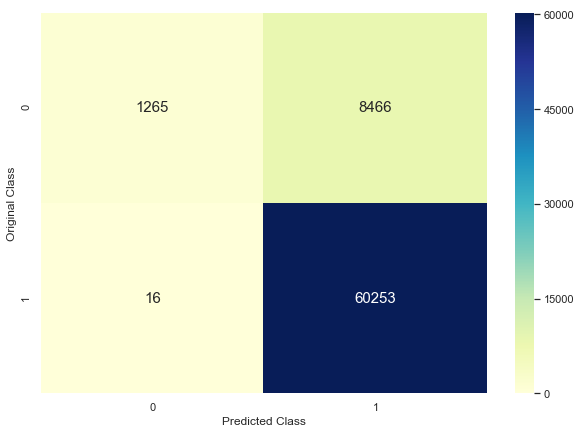

In [625]:
TFIDF_Train2 = confusion_matrix(Y_Train,matrixpredict(Y_Train_pred4,thresholds,train_tpr4,train_fpr4))
plottrainmatrix(TFIDF_Train2)

Accuracy on the Training Data = (60253+1265)/70000 => 87.88 %

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7837671427123124
Threshold for Maximum Value of tpr*(1-fpr) : 0.571


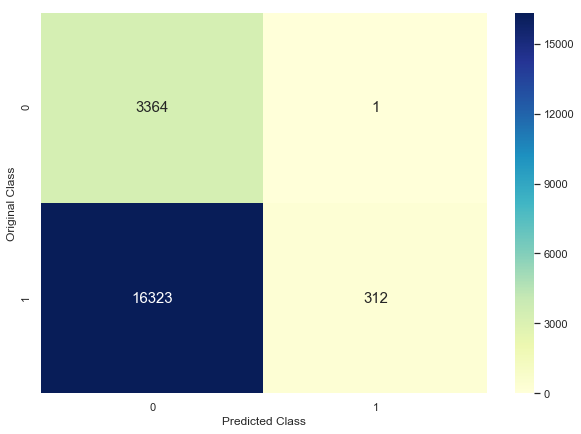

In [626]:
TFIDF_Test2 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred4,thresholds,test_tpr4,test_fpr4))
plottestmatrix(TFIDF_Test2)

Accuracy on the Test Data = (312+3364)/20000 => 18.38 %

# [5.2.3] Feature Importance on TFIDF :-

In [627]:
logi_test3.fit(X_Train_SCTFIDF,Y_Train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [628]:
TFIDF_feature_names = tf_idf_vect.get_feature_names()
W_TFIDF = logi_test3.coef_

In [629]:
TFIDF_sorted_weights = np.argsort(W_TFIDF[0])
print("The length of the TFIDF_sorted_weights vector is as follows: " + str(len(TFIDF_sorted_weights)))
print("The TFIDF_sorted_weights variable looks like as follows:")
print(TFIDF_sorted_weights)

The length of the TFIDF_sorted_weights vector is as follows: 40652
The TFIDF_sorted_weights variable looks like as follows:
[ 9147 24630 40083 ... 14959  2821 15624]


In [630]:
TFIDF_sorted_weights_reversed = list(np.flip(TFIDF_sorted_weights))
len(TFIDF_sorted_weights_reversed)

40652

# [5.2.3.1] Top 10 Important Features of Positive Class for TFIDF (Set 2) :-

In [631]:
print("The Top 10 Important Features of the Positive Class are as follows:")   
print("="*100) 
for i in TFIDF_sorted_weights_reversed[0:10]:
    print(TFIDF_feature_names[i], "-->",round(W_TFIDF[0][i],3))

The Top 10 Important Features of the Positive Class are as follows:
great --> 0.776
best --> 0.545
good --> 0.509
delicious --> 0.474
love --> 0.473
perfect --> 0.359
loves --> 0.308
excellent --> 0.3
wonderful --> 0.271
not disappointed --> 0.257


# [5.2.3.2] Top 10 Important Features of Negative Class for TFIDF (Set 2) :-

In [635]:
print("The Top 10 Important Features of the Negative Class are as follows:")   
print("="*100) 
for i in TFIDF_sorted_weights[0:10]:
    print(TFIDF_feature_names[i], "-->",round(W_TFIDF[0][i],3))

The Top 10 Important Features of the Negative Class are as follows:
disappointed --> -0.293
not worth --> -0.207
worst --> -0.196
not good --> -0.194
not --> -0.172
awful --> -0.171
terrible --> -0.17
not recommend --> -0.166
bad --> -0.16
disappointing --> -0.149


# [5.3] Applying Logistic Regression on Avg W2V :-

In [447]:
list_of_sentence_Train =[]

for sentence in X_Train:
    list_of_sentence_Train.append(sentence.split())

In [448]:
w2v_model=Word2Vec(list_of_sentence_Train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occur a minimum 5 times :",len(w2v_words))
print("Some of the sample words are as follows: ", w2v_words[0:50])

Number of words that occur a minimum 5 times : 15928
Some of the sample words are as follows:  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd']


# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [449]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 70000/70000 [03:30<00:00, 332.04it/s]


(70000, 50)
[-0.26362235  0.36341259  0.05912716 -0.15530241 -0.21291825  0.08224224
 -0.25469363 -0.13862453  0.26894427 -0.26029831 -0.04197873  0.05070011
 -0.0908889   0.24274769 -0.02457227  0.53280742  0.07720621 -0.08869534
  0.21933248 -0.28083922  0.28840151 -0.32265463 -0.03505384 -0.42208762
  0.38699276 -0.08300514 -0.61234964 -0.08876074 -0.09647444  0.21374562
  0.11816004  0.4525831   0.02205687 -0.70755206  0.21486545  0.04888541
  0.15189676 -0.28684302  0.4380355  -0.12291572  0.05511635  0.05907963
  0.15147521  0.17947921  0.09547235 -0.38324617  0.43814488  0.31504052
 -0.01067962 -0.49069129]


# Converting the CV Data Text :- 

In [450]:
list_of_sentence_CV=[]

for sentence in X_CV:
    list_of_sentence_CV.append(sentence.split())

In [451]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 10000/10000 [00:35<00:00, 279.34it/s]

(10000, 50)
[-0.54314212  0.93229    -0.26659426 -0.32557144  0.10203325 -0.09511835
 -0.0601084   0.6061285   0.73678312 -0.5780331  -0.97167579 -0.05995509
  0.641424    1.00823946  0.02411256 -0.59540434 -0.20607784  0.50461223
 -0.43214003 -0.16438693 -0.55799016 -1.00977479 -0.22433989 -0.80314952
  0.67531942  0.24621882 -0.12094076 -1.21701362  0.2590868   0.06028539
  0.24249784  0.22580237 -0.3470416  -0.54390467  0.36592818 -0.5400776
 -0.68841747 -0.44865155  0.21871802 -0.72908377  0.82552079 -0.37377145
 -0.1773099  -0.36782574  0.20512174 -0.08270357  0.39839728  0.55755891
  0.25172036  0.01304174]


# Converting the Test Dataset :- 

In [452]:
list_of_sentence_Test=[]

for sentence in X_Test:
    list_of_sentence_Test.append(sentence.split())

In [453]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 20000/20000 [01:08<00:00, 292.04it/s]

(20000, 50)
[-0.07378932  0.6712336   0.03768263  0.2643882  -0.60631931  0.53480398
 -0.33460285  0.20846627  0.37334804  0.04518424 -0.89149444  0.41057425
  0.2191432   0.30187157  1.02174405  0.95069487  0.74066361 -0.13720857
  0.542327    0.14497826 -0.11830268 -0.07027424  0.71532956 -0.28252261
  0.62837058  0.34923659  0.22613363 -0.31467119 -0.18399634  0.72005026
 -0.20654184  0.86442045  0.17901444 -0.74680024  0.64576795 -0.04478863
 -0.45511976 -0.90311688  0.31090903 -0.41058571  0.12561467  0.00847569
  0.14458226  0.35787313  0.35890088  0.32884971 -0.49603471 -0.62464337
 -0.10627545  0.06020927]


# [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V :-

# Hyperparameter Tuning on the Avg W2V Representation (For L1 Regularization):- 

In [455]:
Scaler3 = StandardScaler(with_mean=False)

X_Train_SCAW2V = Scaler3.fit_transform(sent_vectors_train)
X_CV_SCAW2V = Scaler3.transform(sent_vectors_cv)
X_Test_SCAW2V = Scaler3.transform(sent_vectors_test)

In [467]:
logi5 = LogisticRegression(penalty='l1',fit_intercept=False,class_weight='balanced')
AW2V_model1 = GridSearchCV(logi5,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

AW2V_model1.fit(X_Train_SCAW2V,Y_Train)

Train_AW2V_AUC_L1 = AW2V_model1.cv_results_['mean_train_score']
CV_AW2V_AUC_L1 = AW2V_model1.cv_results_['mean_test_score'] 

Plotting the graph to obtain the Best value of the Hyperparameter C:-

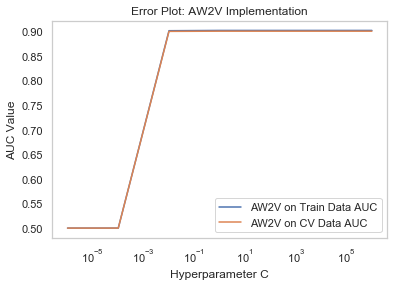

In [468]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_AW2V_AUC_L1,label="AW2V on Train Data AUC")
plt.plot(lambda_hyperparam,CV_AW2V_AUC_L1,label ="AW2V on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: AW2V Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [469]:
print(AW2V_model1.best_params_)

{'C': 1}


# Testing with the Test Data for AW2V Representation (For L1 Regularization) :-

In [470]:
logi_test5 = LogisticRegression(penalty='l1',C=1,fit_intercept=False,class_weight='balanced')
logi_test5.fit(X_Train_SCAW2V,Y_Train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [471]:
X_Train_SCAW2V.shape

(70000, 50)

In [462]:
Y_Train.shape

(70000,)

In [472]:
X_Test_SCAW2V.shape

(20000, 50)

In [464]:
Y_Test.shape

(20000,)

In [476]:
from sklearn.metrics import roc_curve,auc

train_fpr5,train_tpr5,threshold = roc_curve(Y_Train,logi_test5.predict_proba(X_Train_SCAW2V)[:,1])
test_fpr5,test_tpr5,threshold = roc_curve(Y_Test,logi_test5.predict_proba(X_Test_SCAW2V)[:,1])

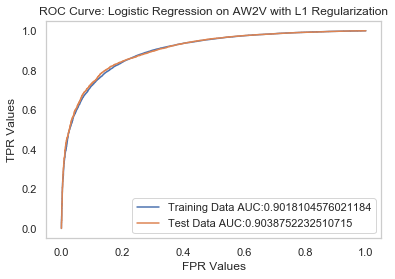

In [477]:
import matplotlib.pyplot as plt

plt.plot(train_fpr5,train_tpr5,label ='Training Data AUC:' + str(auc(train_fpr5,train_tpr5)))
plt.plot(test_fpr5,test_tpr5,label = 'Test Data AUC:' + str(auc(test_fpr5,test_tpr5)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on AW2V with L1 Regularization')

plt.grid(False)
plt.show()

In [478]:
Y_Train_pred5 = logi_test5.predict_proba(X_Train_SCAW2V)[:,1]
Y_Test_pred5 = logi_test5.predict_proba(X_Test_SCAW2V)[:,1]

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6871543778647484
Threshold for Maximum Value of tpr*(1-fpr) : 0.485


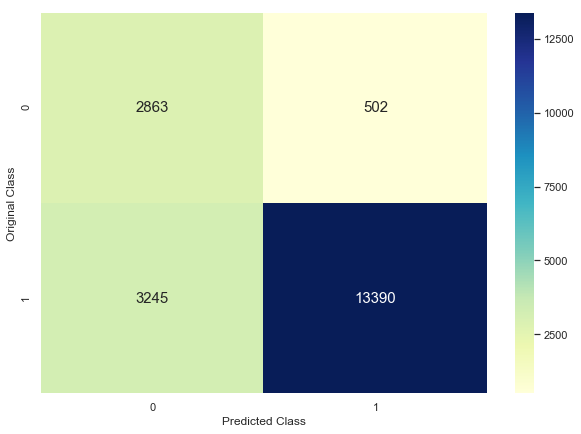

In [481]:
AW2V_Test1 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred5,thresholds,test_tpr5,test_fpr5))
plottestmatrix(AW2V_Test1)

Accuracy on the Test Data = (13390+2863)/20000 => 81.27 %

# [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V :-

# Hyperparameter Tuning on the Avg W2V Representation (For L1 Regularization):- 

In [482]:
logi6 = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced')
AW2V_model2 = GridSearchCV(logi6,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

AW2V_model2.fit(X_Train_SCAW2V,Y_Train)

Train_AW2V_AUC_L2 = AW2V_model2.cv_results_['mean_train_score']
CV_AW2V_AUC_L2 = AW2V_model2.cv_results_['mean_test_score'] 

Plotting the graph for the Best Value of the Hyperparameter C, we obtain the following:

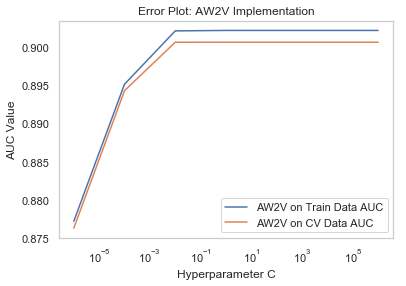

In [483]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_AW2V_AUC_L2,label="AW2V on Train Data AUC")
plt.plot(lambda_hyperparam,CV_AW2V_AUC_L2,label ="AW2V on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: AW2V Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [485]:
print(AW2V_model2.best_params_)

{'C': 1}


Again we have obtained the best value of the Hyperparameter C to be equal to 1.

# Testing with the Test Data for AW2V Representation (For L2 Regularization) :-

In [491]:
logi_test6 = LogisticRegression(penalty='l2',C=1,fit_intercept=False,class_weight='balanced')
logi_test6.fit(X_Train_SCAW2V,Y_Train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [492]:
X_Train_SCAW2V.shape

(70000, 50)

In [493]:
Y_Train.shape

(70000,)

In [494]:
X_Test_SCAW2V.shape

(20000, 50)

In [495]:
Y_Test.shape

(20000,)

In [496]:
from sklearn.metrics import roc_curve,auc

train_fpr6,train_tpr6,threshold = roc_curve(Y_Train,logi_test6.predict_proba(X_Train_SCAW2V)[:,1])
test_fpr6,test_tpr6,threshold = roc_curve(Y_Test,logi_test6.predict_proba(X_Test_SCAW2V)[:,1])

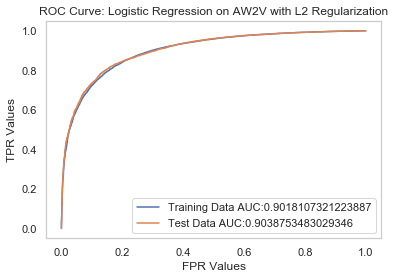

In [497]:
import matplotlib.pyplot as plt

plt.plot(train_fpr6,train_tpr6,label ='Training Data AUC:' + str(auc(train_fpr6,train_tpr6)))
plt.plot(test_fpr6,test_tpr6,label = 'Test Data AUC:' + str(auc(test_fpr6,test_tpr6)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on AW2V with L2 Regularization')

plt.grid(False)
plt.show()

In [498]:
Y_Train_pred6 = logi_test6.predict_proba(X_Train_SCAW2V)[:,1]
Y_Test_pred6 = logi_test6.predict_proba(X_Test_SCAW2V)[:,1]

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6870121581673828
Threshold for Maximum Value of tpr*(1-fpr) : 0.499


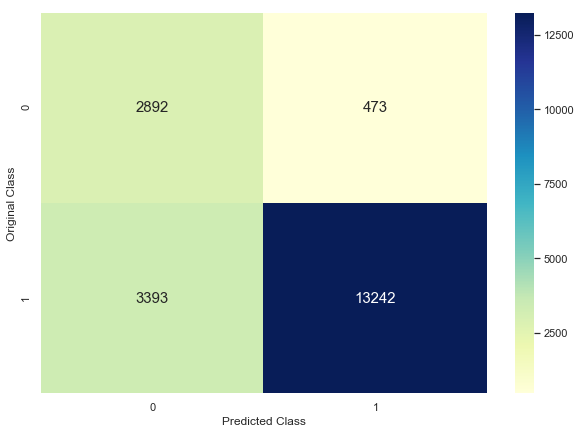

In [499]:
AW2V_Test2 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred6,thresholds,test_tpr6,test_fpr6))
plottestmatrix(AW2V_Test2)

Accuracy on the Test Data = (13242+2892)/20000 => 80.67 %

# [5.4] Applying Logistic Regression on TFIDF W2V :-

In [500]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_Train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [501]:
tf_idf_matrix.shape

(70000, 49871)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [502]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [2:26:25<00:00,  7.97it/s]     


In [503]:
tfidf_sent_vectors_train[1]

array([-0.1377085 ,  0.57922791, -0.26778645,  0.00927131, -0.31480139,
       -0.09514315, -0.45718019, -0.3459088 ,  0.57188027, -0.23613721,
       -0.3367774 ,  0.33397561,  0.14271972,  0.0145354 ,  0.14699015,
        0.25031593, -0.13074571, -0.20908718,  0.26968004,  0.02424442,
        0.38539809, -0.39909051,  0.34158593, -0.2152388 ,  0.71684167,
        0.08013011, -0.41634708,  0.03336402,  0.16538415,  0.08156946,
       -0.12341729,  0.48609311,  0.07896668, -0.23647025,  0.02374171,
       -0.20066829,  0.1111161 , -0.10216669,  0.23018917, -0.01845567,
       -0.08628821,  0.00216192,  0.12506644,  0.09857979, -0.14456786,
       -0.63768659,  0.63804906,  0.49433737, -0.39536   , -0.76087556])

# Converting the CV Data Text :-

In [504]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [07:47<00:00, 21.41it/s]


# Converting the Test Data Text :-

In [505]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [17:45<00:00, 18.77it/s] 


# [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V :-

# Hyperparameter Tuning on the TFIDF W2V Representation (For L1 Regularization):- 

In [506]:
Scaler4 = StandardScaler(with_mean=False)

X_Train_SCTFIDFW2V = Scaler4.fit_transform(tfidf_sent_vectors_train)
X_CV_SCTFIDFW2V = Scaler4.transform(tfidf_sent_vectors_cv)
X_Test_SCTFIDFW2V = Scaler4.transform(tfidf_sent_vectors_test)

In [507]:
logi7 = LogisticRegression(penalty='l1',fit_intercept=False,class_weight='balanced')
TFIDFW2V_model1 = GridSearchCV(logi7,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

TFIDFW2V_model1.fit(X_Train_SCTFIDFW2V,Y_Train)

Train_TFIDFW2V_AUC_L1 = TFIDFW2V_model1.cv_results_['mean_train_score']
CV_TFIDFW2V_AUC_L1 = TFIDFW2V_model1.cv_results_['mean_test_score'] 

Plotting the graph to find the best value of the Hyperparameter C, we obtain the following:-

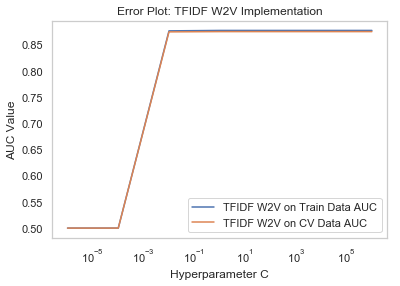

In [508]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_TFIDFW2V_AUC_L1,label="TFIDF W2V on Train Data AUC")
plt.plot(lambda_hyperparam,CV_TFIDFW2V_AUC_L1,label ="TFIDF W2V on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: TFIDF W2V Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [509]:
print(TFIDFW2V_model1.best_params_)

{'C': 1}


Again we obtain the Best value of the hyperparameter to be equal to 1.

# Testing with the Test Data for TFIDF W2V Representation (For L1 Regularization) :-

In [510]:
logi_test7 = LogisticRegression(penalty='l1',C=1,fit_intercept=False,class_weight='balanced')
logi_test7.fit(X_Train_SCTFIDFW2V,Y_Train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [511]:
X_Train_SCTFIDFW2V.shape

(70000, 50)

In [512]:
Y_Train.shape

(70000,)

In [513]:
X_Test_SCTFIDFW2V.shape

(20000, 50)

In [514]:
Y_Test.shape

(20000,)

In [515]:
from sklearn.metrics import roc_curve,auc

train_fpr7,train_tpr7,threshold = roc_curve(Y_Train,logi_test7.predict_proba(X_Train_SCTFIDFW2V)[:,1])
test_fpr7,test_tpr7,threshold = roc_curve(Y_Test,logi_test7.predict_proba(X_Test_SCTFIDFW2V)[:,1])

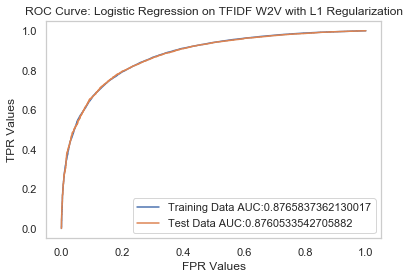

In [516]:
import matplotlib.pyplot as plt

plt.plot(train_fpr7,train_tpr7,label ='Training Data AUC:' + str(auc(train_fpr7,train_tpr7)))
plt.plot(test_fpr7,test_tpr7,label = 'Test Data AUC:' + str(auc(test_fpr7,test_tpr7)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on TFIDF W2V with L1 Regularization')

plt.grid(False)
plt.show()

In [517]:
Y_Train_pred7 = logi_test7.predict_proba(X_Train_SCTFIDFW2V)[:,1]
Y_Test_pred7 = logi_test7.predict_proba(X_Test_SCTFIDFW2V)[:,1]

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6372540040043393
Threshold for Maximum Value of tpr*(1-fpr) : 0.433


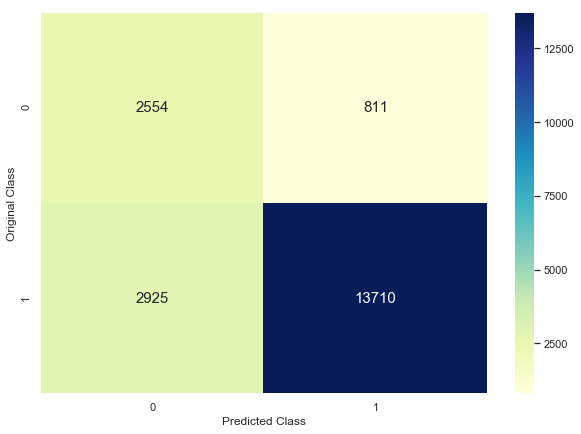

In [518]:
TFIDFW2V_Test1 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred7,thresholds,test_tpr7,test_fpr7))
plottestmatrix(TFIDFW2V_Test1)

Accuracy on the Test Data = (13710+2554)/20000 => 81.32%

# [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V :-

# Hyperparameter Tuning on the TFIDF W2V Representation (For L2 Regularization):- 

In [519]:
logi8 = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced')
TFIDFW2V_model2 = GridSearchCV(logi8,tuned_parameters,scoring='roc_auc',cv=3,n_jobs=-1)

TFIDFW2V_model2.fit(X_Train_SCTFIDFW2V,Y_Train)

Train_TFIDFW2V_AUC_L2 = TFIDFW2V_model2.cv_results_['mean_train_score']
CV_TFIDFW2V_AUC_L2 = TFIDFW2V_model2.cv_results_['mean_test_score'] 

Plotting the graph to find the best value of the Hyperparameter C, we obtain the following:-

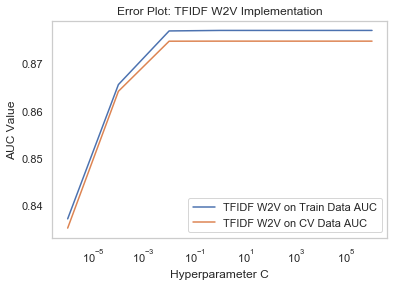

In [520]:
import matplotlib.pyplot as plt

plt.plot(lambda_hyperparam,Train_TFIDFW2V_AUC_L2,label="TFIDF W2V on Train Data AUC")
plt.plot(lambda_hyperparam,CV_TFIDFW2V_AUC_L2,label ="TFIDF W2V on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.title("Error Plot: TFIDF W2V Implementation")
plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')

plt.show()

In [521]:
print(TFIDFW2V_model2.best_params_)

{'C': 1}


# Testing with the Test Data for TFIDF W2V Representation (For L2 Regularization) :-

In [522]:
logi_test8 = LogisticRegression(penalty='l2',C=1,fit_intercept=False,class_weight='balanced')
logi_test8.fit(X_Train_SCTFIDFW2V,Y_Train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [523]:
X_Train_SCTFIDFW2V.shape

(70000, 50)

In [524]:
Y_Train.shape

(70000,)

In [525]:
X_Test_SCTFIDFW2V.shape

(20000, 50)

In [526]:
Y_Test.shape

(20000,)

In [527]:
from sklearn.metrics import roc_curve,auc

train_fpr8,train_tpr8,threshold = roc_curve(Y_Train,logi_test8.predict_proba(X_Train_SCTFIDFW2V)[:,1])
test_fpr8,test_tpr8,threshold = roc_curve(Y_Test,logi_test8.predict_proba(X_Test_SCTFIDFW2V)[:,1])

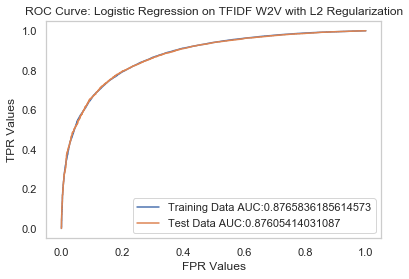

In [528]:
import matplotlib.pyplot as plt

plt.plot(train_fpr8,train_tpr8,label ='Training Data AUC:' + str(auc(train_fpr8,train_tpr8)))
plt.plot(test_fpr8,test_tpr8,label = 'Test Data AUC:' + str(auc(test_fpr8,test_tpr8)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Logistic Regression on TFIDF W2V with L2 Regularization')

plt.grid(False)
plt.show()

In [529]:
Y_Train_pred8 = logi_test8.predict_proba(X_Train_SCTFIDFW2V)[:,1]
Y_Test_pred8 = logi_test8.predict_proba(X_Test_SCTFIDFW2V)[:,1]

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6373380209917416
Threshold for Maximum Value of tpr*(1-fpr) : 0.425


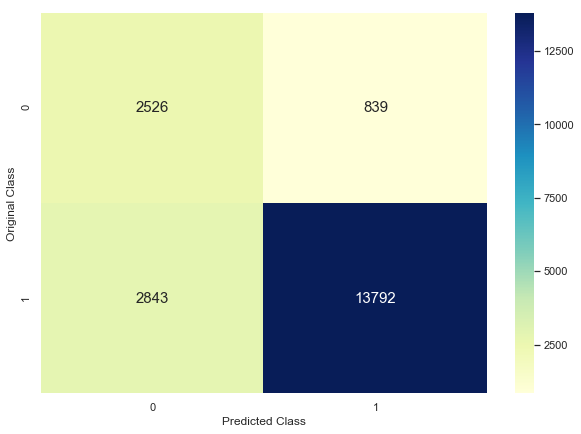

In [530]:
TFIDFW2V_Test2 = confusion_matrix(Y_Test,matrixpredict(Y_Test_pred8,thresholds,test_tpr8,test_fpr8))
plottestmatrix(TFIDFW2V_Test2)

Accuracy on Test Data = (13792+2526)/20000 => 81.59%

# [6] Conclusions :-

In [636]:
from prettytable import PrettyTable

In [637]:
x=PrettyTable()
x.field_names=["S No.","Top 10 Positive Words","Weight(+ve)","Top 10 Negative Words","Weight(-ve)"]

In [638]:
print("Top 10 Positive and Negative Words with BOW Representation:")
print(" "*100)

x.add_row(["1","great","0.685","not","-0.631"])
x.add_row(["2","best","0.536","disappointed","-0.251"])
x.add_row(["3","delicious","0.496","worst","-0.226"])
x.add_row(["4","good","0.403","terrible","-0.204"])
x.add_row(["5","perfect","0.375","awful","-0.185"])
x.add_row(["6","love","0.368","horrible","-0.169"])
x.add_row(["7","loves","0.318","thought","-0.169"])
x.add_row(["8","excellent","0.318","disappointing","-0.168"])
x.add_row(["9","highly","0.313","unfortunately","-0.165"])
x.add_row(["10","wonderful","0.272","money","-0.144"])

print(x)

Top 10 Positive and Negative Words with BOW Representation:
                                                                                                    
+-------+-----------------------+-------------+-----------------------+-------------+
| S No. | Top 10 Positive Words | Weight(+ve) | Top 10 Negative Words | Weight(-ve) |
+-------+-----------------------+-------------+-----------------------+-------------+
|   1   |         great         |    0.685    |          not          |    -0.631   |
|   2   |          best         |    0.536    |      disappointed     |    -0.251   |
|   3   |       delicious       |    0.496    |         worst         |    -0.226   |
|   4   |          good         |    0.403    |        terrible       |    -0.204   |
|   5   |        perfect        |    0.375    |         awful         |    -0.185   |
|   6   |          love         |    0.368    |        horrible       |    -0.169   |
|   7   |         loves         |    0.318    |        thought   

In [639]:
y=PrettyTable()
y.field_names=["S No.","Top 10 Positive Words","Weight(+ve)","Top 10 Negative Words","Weight(-ve)"]

In [640]:
print("Top 10 Positive and Negative Words with TFIDF Representation:")
print(" "*100)

y.add_row(["1","great","0.776","disappointed","-0.293"])
y.add_row(["2","best","0.545","not worth","-0.207"])
y.add_row(["3","good","0.509","worst","-0.196"])
y.add_row(["4","delicious","0.474","not good","-0.194"])
y.add_row(["5","love","0.473","not","-0.172"])
y.add_row(["6","perfect","0.359","awful","-0.171"])
y.add_row(["7","loves","0.308","terrible","-0.170"])
y.add_row(["8","excellent","0.300","not recommend","-0.166"])
y.add_row(["9","wonderful","0.271","bad","-0.160"])
y.add_row(["10","not disappointed","0.257","disappointing","-0.149"])

print(y)

Top 10 Positive and Negative Words with TFIDF Representation:
                                                                                                    
+-------+-----------------------+-------------+-----------------------+-------------+
| S No. | Top 10 Positive Words | Weight(+ve) | Top 10 Negative Words | Weight(-ve) |
+-------+-----------------------+-------------+-----------------------+-------------+
|   1   |         great         |    0.776    |      disappointed     |    -0.293   |
|   2   |          best         |    0.545    |       not worth       |    -0.207   |
|   3   |          good         |    0.509    |         worst         |    -0.196   |
|   4   |       delicious       |    0.474    |        not good       |    -0.194   |
|   5   |          love         |    0.473    |          not          |    -0.172   |
|   6   |        perfect        |    0.359    |         awful         |    -0.171   |
|   7   |         loves         |    0.308    |        terrible

In [642]:
z = PrettyTable()
z.field_names=["S No.","Model","Best Value of C","Test Accuracy on Ideal Threshold","Test AUC Score"]

In [643]:
z.add_row(["1","BOW (L1 Regularization)","0.001","87.70%","0.940"])
z.add_row(["2","BOW (L2 Regularization)","0.0001","86.64%","0.925"])
z.add_row(["3","TFIDF (L1 Regularization)","0.01","88.80%","0.960"])
z.add_row(["4","TFIDF (L2 Regularization)","10^(-6)","18.38%","0.954"])
z.add_row(["5","AW2V (L1 Regularization)","1","81.27%","0.904"])
z.add_row(["6","AW2V (L2 Regularization)","1","80.67%","0.904"])
z.add_row(["7","TFIDF W2V (L1 Regularization)","1","81.32%","0.876"])
z.add_row(["8","TFIDF W2V (L2 Regularization)","1","81.59%","0.876"])

print(z)

+-------+-------------------------------+-----------------+----------------------------------+----------------+
| S No. |             Model             | Best Value of C | Test Accuracy on Ideal Threshold | Test AUC Score |
+-------+-------------------------------+-----------------+----------------------------------+----------------+
|   1   |    BOW (L1 Regularization)    |      0.001      |              87.70%              |     0.940      |
|   2   |    BOW (L2 Regularization)    |      0.0001     |              86.64%              |     0.925      |
|   3   |   TFIDF (L1 Regularization)   |       0.01      |              88.80%              |     0.960      |
|   4   |   TFIDF (L2 Regularization)   |     10^(-6)     |              18.38%              |     0.954      |
|   5   |    AW2V (L1 Regularization)   |        1        |              81.27%              |     0.904      |
|   6   |    AW2V (L2 Regularization)   |        1        |              80.67%              |     0.904

<b> <font color="black"> Following are some Conclusions from the observations:- </font> </b>

* The Sparsity obtained on the BOW Weight Vector obtained after L1 Regularization is equal to 0.88.
* The Best Model in this scenario (as can be seen from the table above) is the TFIDF Model when L1 Regularization 
  is carried out, which has a high value of Test Accuracy (88.80%) as well as the Highest Test AUC Score = 0.960.
* The Next Best Model would be BOW with L1 Regularization, considering both Test Accuracy as well as the Test AUC       Scores. Even though TFIDF with L2 Regularization has a better AUC Score of 0.954, but its Test Accuracy is       really terrible (only equal to 18.38%).